In [2]:
import tensorflow as tf
import numpy as np,sys,os
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import SimpleITK as sitk
import os as os
import nrrd as reader
import pandas as pd
import cv2 
import csv
from sklearn.model_selection import train_test_split
from keras.models import load_model
from tqdm import tqdm
from tabulate import tabulate
from skimage import morphology
from skimage import measure
from skimage import segmentation
from skimage.segmentation import flood, flood_fill
from skimage.measure import label
from skimage.segmentation import active_contour
from skimage import data, io, img_as_ubyte,filters
from time import sleep
from IPython.display import clear_output

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Create virtual GPUs
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    print(e)

  # Check if TensorFlow is using your GPU
  print(tf.config.list_physical_devices('GPU'))
#This code will create virtual GPUs and check if TensorFlow is using your GPU. 
#If the output of the print() function contains one or more entries, then TensorFlow is using your GPU.

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
#Loading previously processed DCM and Mask arrays into NumPy arrays.
# RawDCMArray = np.load("RAW-DCM-ARRAY.npy")
NormDCMArray = np.load("Iso-Thigh.npy")


In [ ]:
def multi_otsu(image):
    motsuth=filters.threshold_multiotsu(image, classes=3)
    print(motsuth)
    print (f"Slice {i+1} otsu threshold={motsuth[1]}")
    print("----------------------------------------------")
    return motsuth[1]

iThreshold=[]
print('Multi Otsu Threshold...')
for i in range(201):
    iThreshold.append([])
    iThreshold[i]=multi_otsu(CorrectedFascia[i])


In [ ]:
def ITSA(i,InROI, ots, OG_VOL):
    k=1
    ThPrev=0 
    ThRev= ots[i] 
    x=0
    y=0
    
    while ThRev!=ThPrev:
        ThPrev=ThRev
        prefatmask = (InROI[i]>ThRev)
        prefatmask = np.uint8(prefatmask)
        ret, fatmask = cv2.threshold(prefatmask,0,1,cv2.THRESH_BINARY) 
        if i==0:
            fatcombined_next=OG_VOL[i+1]+fatmask
            ret, fatconnectedparts_next= cv2.threshold(fatcombined_next,1,1,cv2.THRESH_BINARY)
            z_connection=fatconnectedparts_next
        elif i==(totalslices-1):
            fatcombined_prev=OG_VOL[i-1]+fatmask
            ret, fatconnectedparts_prev= cv2.threshold(fatcombined_prev,1,1,cv2.THRESH_BINARY)
            z_connection=fatconnectedparts_prev  
        else:
            fatcombined_prev=OG_VOL[i-1]+fatmask
            fatcombined_next=fatmask+OG_VOL[i+1]
            ret, fatconnectedparts_prev= cv2.threshold(fatcombined_prev,1,1,cv2.THRESH_BINARY)
            ret, fatconnectedparts_next= cv2.threshold(fatcombined_next,1,1,cv2.THRESH_BINARY)

            z_connection=fatconnectedparts_prev+fatconnectedparts_next
            ret, z_connection= cv2.threshold(z_connection,0,1,cv2.THRESH_BINARY)         
        #NEW: find XY connections to Z connected parts
        coordinates= np.argwhere(z_connection ==1) #put coordinates of Z-connections into a list      
        im_ff=fatmask.copy()
        h, w = im_ff.shape[:2] #added
        mask = np.zeros((h+2, w+2), np.uint8)
        for item in range(len(coordinates)):
            cv2.floodFill(im_ff, mask, (coordinates[item][1],coordinates[item][0]), 2) 
        #Remove small islands for Non-Z parts
        nonZ =label(im_ff==1)
        nonZ_keep = (morphology.remove_small_objects(nonZ,min_size=8, connectivity=1))
        ret, nonZ_keep= cv2.threshold(np.uint8(nonZ_keep),0,1,cv2.THRESH_BINARY)
        Z = (im_ff==2)
        prefatseg1=(Z+nonZ_keep) 
        fatseg1=prefatseg1*InROI[i]
        #Fat and Muscle Quantification
        preMuscSegP=InROI[i]-fatseg1
        MuscSegP=np.ma.masked_where(preMuscSegP == 0, preMuscSegP)
        MuscSeg = InROI[i]*MuscSegP
        FatSegP=np.ma.masked_where(fatseg1==0,fatseg1) 
        Placeholder, FatSegOutput=cv2.threshold(fatseg1,0,1,cv2.THRESH_BINARY) #Threshold (Kenneth edit**)
        MuscSegI=np.mean(MuscSegP)
        FatSegI=np.mean(FatSegP)
        ThRev=(1+((FatSegI-MuscSegI)/FatSegI))*MuscSegI
        print (f"Slice #{i+1} Iteration={k}\n\tThPrev={ThPrev}\n\tThRev={ThRev}\n")

        k+=1
        if k==50:
            break

    thresholds = ThRev
    
    return FatSegOutput,thresholds

#ITSA Threshold Seeking Round 1 
fleROI_R1=np.zeros([thigharray.shape[0], thigharray.shape[1], thigharray.shape[2]], dtype='uint8')
fatseg=np.zeros([thigharray.shape[0], thigharray.shape[1], thigharray.shape[2]], dtype='uint8')
fatsegMASK=np.zeros([thigharray.shape[0], thigharray.shape[1], thigharray.shape[2]], dtype='uint8') #change name
threshold_R1=[] 
print("ITSA Round 1 Initiation...")
for i in range(201):
    threshold_R1.append([])
    fatsegMASK[i],threshold_R1[i]=ITSA(i, CorrectedFascia, iThreshold,OG_VOL )  
    print (f"Slice #{i+1} Round 1 Th1 = {threshold_R1[i]}")
    print ("-----------------------------------------------------------")
    
for i in range(201):
    print (f"Slice #{i+1} Th1 OG/Rev={threshold_R1[i]}")

In [7]:
def join(one, two):
    return os.path.join(one, two)

def check_path(path):
    count=0
    for files in sorted(os.listdir(path)):
        image_path = os.path.join(path,files)
        count+=1
    return count

num_patients =check_path(join(os.getcwd(), "dicom"))
folder_path=join(os.getcwd(), "assets/modelv2_1.h5")

In [3]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate
def unet(input_shape):
    inputs = Input(input_shape)
    
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    up6 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = Concatenate()([drop4, up6])
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)
    
    up7 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = Concatenate()([conv3, up7])
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)
    
    up8 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = Concatenate()([conv2, up8])
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)
    
    up9 = Conv2D(32, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = Concatenate()([conv1, up9])
    conv9 = Conv2D(32, 3, activation ='relu', padding='same')(merge9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(conv9)
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)

    return model

## Fascia Version 2_1

In [9]:
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

dicoms = (DCMArray - np.min(DCMArray)) / (np.max(DCMArray) - np.min(DCMArray))
masks = (FLEMaskArray - np.min(FLEMaskArray)) / (np.max(FLEMaskArray) - np.min(FLEMaskArray))

# Split your data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(dicoms, masks, test_size=0.2)

# Define your loss function and optimizer
loss = 'binary_crossentropy'
optimizer = Adam(learning_rate=1e-4)

#Adding callbacks and model checkpoint
keras_callbacks = [
    EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.0001),
    ModelCheckpoint(folder_path, monitor='val_loss', save_best_only=True, mode='min')
]
# Compile your model
model = unet(dicoms[0].shape)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train your model using the fit() function
history = model.fit(x_train, y_train, batch_size=15, epochs=128, validation_data=(x_val, y_val),callbacks=keras_callbacks)

Epoch 1/128
295/295 [==============================] - 58s 188ms/step - loss: 0.1372 - accuracy: 0.9429 - val_loss: 0.0456 - val_accuracy: 0.9828
Epoch 2/128
295/295 [==============================] - 54s 182ms/step - loss: 0.0227 - accuracy: 0.9906 - val_loss: 0.0228 - val_accuracy: 0.9914
Epoch 3/128
295/295 [==============================] - 54s 182ms/step - loss: 0.0169 - accuracy: 0.9930 - val_loss: 0.0181 - val_accuracy: 0.9926
Epoch 4/128
295/295 [==============================] - 54s 182ms/step - loss: 0.0139 - accuracy: 0.9942 - val_loss: 0.0163 - val_accuracy: 0.9932
Epoch 5/128
295/295 [==============================] - 53s 181ms/step - loss: 0.0121 - accuracy: 0.9949 - val_loss: 0.0156 - val_accuracy: 0.9935
Epoch 6/128
295/295 [==============================] - 53s 181ms/step - loss: 0.0107 - accuracy: 0.9955 - val_loss: 0.0118 - val_accuracy: 0.9950
Epoch 7/128
295/295 [==============================] - 53s 181ms/step - loss: 0.0097 - accuracy: 0.9959 - val_loss: 0.0102 -

Epoch 57/128
295/295 [==============================] - 53s 178ms/step - loss: 0.0033 - accuracy: 0.9986 - val_loss: 0.0039 - val_accuracy: 0.9984
Epoch 58/128
295/295 [==============================] - 52s 177ms/step - loss: 0.0035 - accuracy: 0.9985 - val_loss: 0.0041 - val_accuracy: 0.9983
Epoch 59/128
295/295 [==============================] - 53s 178ms/step - loss: 0.0032 - accuracy: 0.9986 - val_loss: 0.0041 - val_accuracy: 0.9983
Epoch 60/128
295/295 [==============================] - 53s 179ms/step - loss: 0.0032 - accuracy: 0.9986 - val_loss: 0.0043 - val_accuracy: 0.9982
Epoch 61/128
295/295 [==============================] - 53s 179ms/step - loss: 0.0031 - accuracy: 0.9986 - val_loss: 0.0039 - val_accuracy: 0.9984
Epoch 62/128
295/295 [==============================] - 53s 179ms/step - loss: 0.0030 - accuracy: 0.9987 - val_loss: 0.0040 - val_accuracy: 0.9983
Epoch 63/128
295/295 [==============================] - 53s 180ms/step - loss: 0.0031 - accuracy: 0.9987 - val_loss: 0

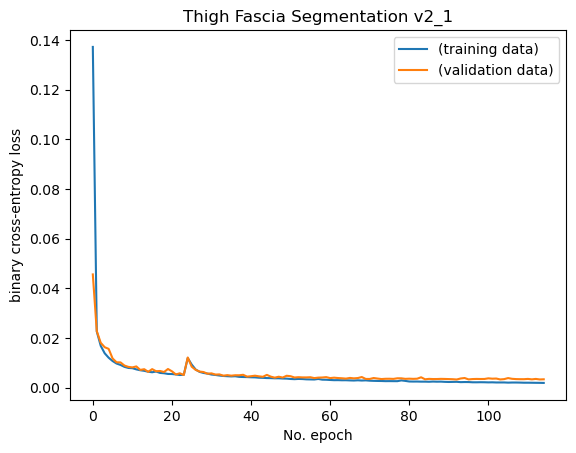

In [11]:
plt.plot(history.history['loss'], label='(training data)')
plt.plot(history.history['val_loss'], label='(validation data)')
plt.title('Thigh Fascia Segmentation v2_1')
plt.ylabel('binary cross-entropy loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

## Fascia Version 2_1 Evaluation

In [21]:
# Split your data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(dicoms, masks, test_size=0.2)
scores = model.evaluate(x_train, y_train, verbose=1)
print(f'Score: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

138/138 [==============================] - 70s 510ms/step - loss: 0.0019 - accuracy: 0.9992
Score: loss of 0.0019395813578739762; accuracy of 99.92024898529053%
